In [1]:
import cv2
import numpy as np
import time
from matplotlib import pyplot as plt

%matplotlib inline

## テスト画像

In [2]:
input_file = cv2.imread('../img/unprocessed/IMG_7455.jpg')

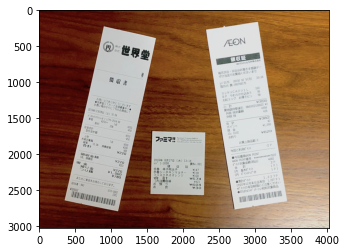

In [3]:
plt.imshow(cv2.cvtColor(input_file, cv2.COLOR_BGR2RGB))
plt.show()

## 案1　グレースケールに変換する前に、減色しておく

In [4]:
def sub_color(img, K):
    pixels = img.reshape(-1, 3).astype(np.float32)
    criteria = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 10, 1.0
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    _, labels, centers = cv2.kmeans(pixels, K, None, criteria, attempts, flags)
    sub_color_img = centers[labels].reshape(img.shape).astype(np.uint8)
    plot_img(sub_color_img)
    return sub_color_img


def plot_histgram(img):
    hist = cv2.calcHist([img], [0], None, [256], [0,256])
    plt.bar([i for i in range(0,256)], hist.ravel())
    plt.show()


def binarize(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plot_img(gray_img)
    _, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_OTSU)
    plot_img(binary_img)
    return gray_img, binary_img


def find_contours(img):
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            if len(approx_contour) == 4:  # 四角形として検知できていない場合は無視する
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours):
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file)


def plot_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    #cv2.imwrite('./{}.png'.format(time.time()), img)


def get_receipt_contours(img, K):
    sub_color_img = sub_color(img, K)
    gray_img, binary_img = binarize(sub_color_img)
    contours = find_contours(binary_img)
    plot_histgram(gray_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, approx_contours)

5色に減色した場合

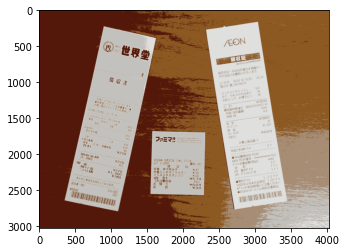

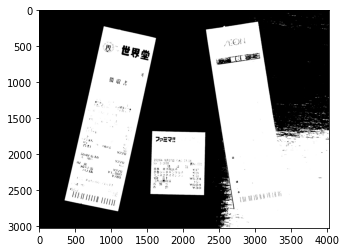

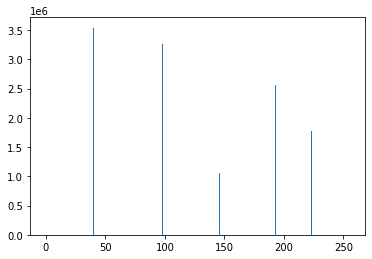

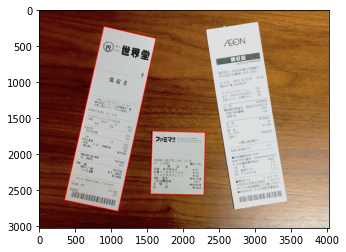

In [5]:
get_receipt_contours(input_file, 5)

### 案1の改善　減色した後の2値化の閾値を任意で決める

In [6]:
def binarize(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold = np.unique(np.array(gray_img).ravel())[-2] -1  # 白側から2色の位置で閾値を置く
    plot_img(gray_img)
    _, binary_img = cv2.threshold(gray_img, threshold, 255, cv2.THRESH_BINARY)
    plot_img(binary_img)
    return gray_img, binary_img


def get_receipt_contours(img, K):
    sub_color_img = sub_color(img, K)
    gray_img, binary_img = binarize(sub_color_img)
    contours = find_contours(binary_img)
    plot_histgram(gray_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, approx_contours)

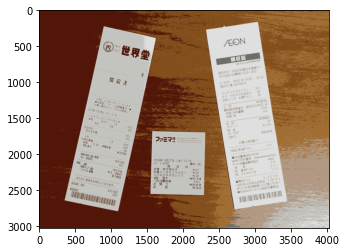

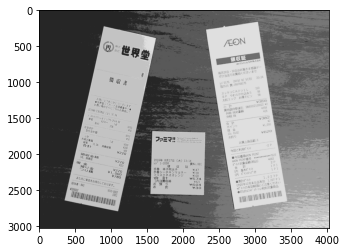

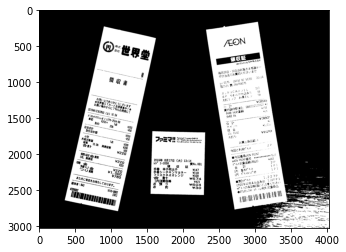

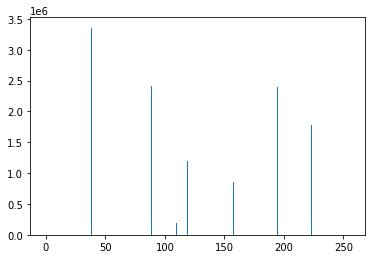

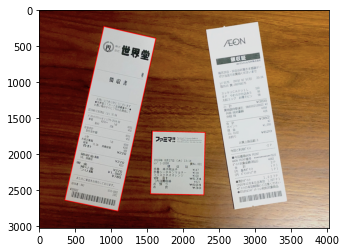

In [7]:
get_receipt_contours(input_file, 7)

## 案2　HSV空間で白の範囲を指定する

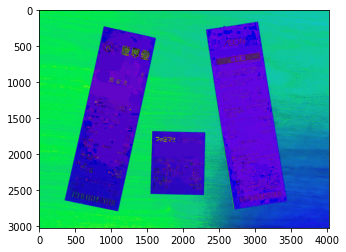

In [8]:
hsv_img = cv2.cvtColor(input_file, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_img)
plt.show()

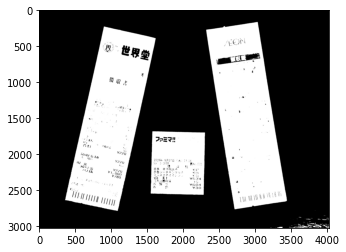

In [9]:
#lower_white = np.array([0,0,230])
#upper_white = np.array([180,15,255])

lower_white = np.array([0,0,100])
upper_white = np.array([180,25,255])
# 白以外にマスク
mask_white = cv2.inRange(hsv_img, lower_white, upper_white)
#res_white = cv2.bitwise_and(input_file, input_file, mask=mask_white)

#plt.imshow(mask_white)
plt.imshow(cv2.cvtColor(mask_white, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
def binarize(hsv_img):
    lower_white = np.array([0,0,100])
    upper_white = np.array([180,25,255])
    binary_img = cv2.inRange(hsv_img, lower_white, upper_white)
    plot_img(binary_img)
    return binary_img


def find_contours(img):
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            if len(approx_contour) == 4:  # 四角形として検知できていない場合は無視する
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours):
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file)


def plot_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    #cv2.imwrite('./{}.png'.format(time.time()), img)


def get_receipt_contours(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    binary_img = binarize(hsv_img)
    contours = find_contours(binary_img)
    #draw_contours_file = cv2.drawContours(input_file.copy(), contours, -1, (0, 0, 255), 10)
    #plot_img(draw_contours_file)
    draw_contours(img, contours)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, approx_contours)

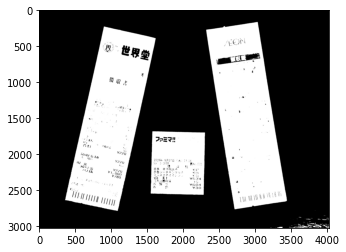

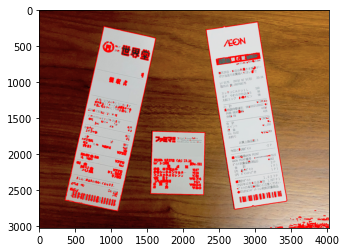

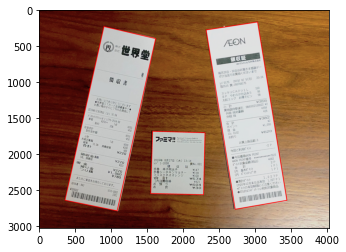

In [11]:
get_receipt_contours(input_file)

## 案3　エッジ検出

In [12]:
gray_img = cv2.cvtColor(input_file, cv2.COLOR_BGR2GRAY)

In [13]:
def plot_img(img):
    img_uint8 = img.astype('uint8')
    plt.imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))
    plt.show()
    # cv2.imwrite('./{}.png'.format(time.time()), img)

### Sobel法

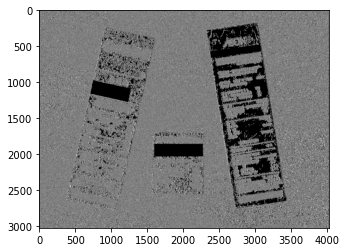

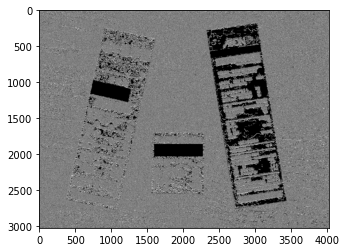

In [14]:
sobelx = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray_img, cv2.CV_32F, 0, 1, ksize=5)

plot_img(sobelx)
plot_img(sobely)

### Laplacian法

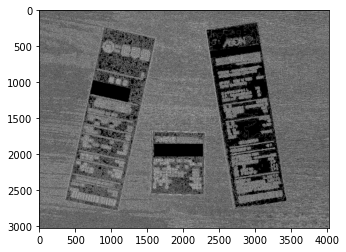

In [15]:
img_lap = cv2.Laplacian(gray_img, cv2.CV_32F)
plot_img(img_lap)

### Canny法

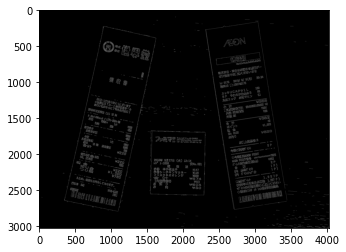

In [16]:
canny = cv2.Canny(gray_img, 100, 200)
plot_img(canny)

閾値変えて見てみる

A. max_valのみ変える

100


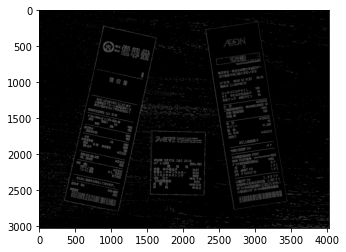

200


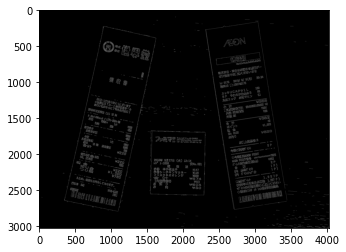

300


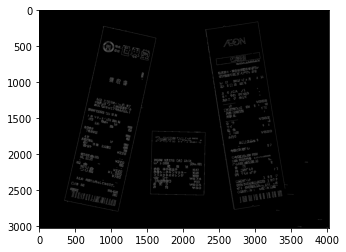

400


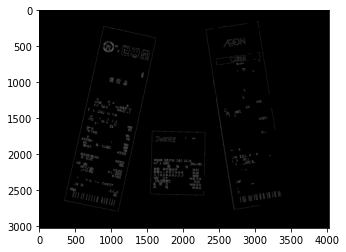

In [17]:
for max_val in [100, 200, 300, 400]:
    canny = cv2.Canny(gray_img, 100, max_val)
    print(max_val)
    plot_img(canny)

B. min_valのみ変える

10


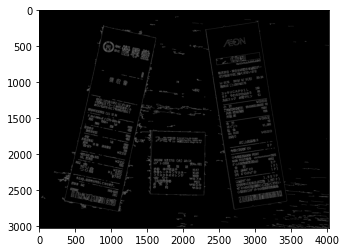

100


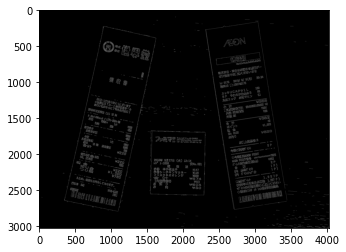

200


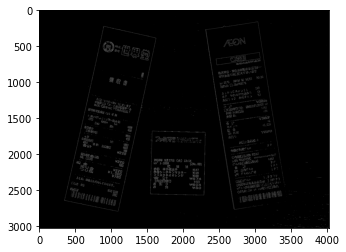

300


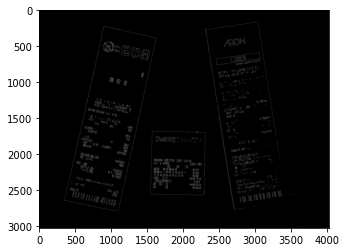

400


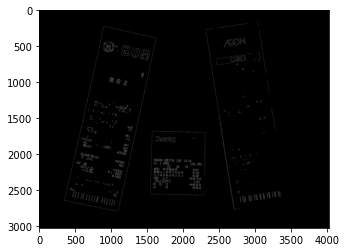

In [18]:
for min_val in [10, 100, 200, 300, 400]:
    canny = cv2.Canny(gray_img, min_val, 200)
    print(min_val)
    plot_img(canny)

### 実際に矩形検知に活用すると

In [19]:
def binarize(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_img = cv2.Canny(gray_img, 100, 200)
    #binary_img = cv2.Laplacian(gray_img, cv2.CV_32F)
    #binary_img = cv2.Sobel(gray_img, cv2.CV_32F, 1, 0, ksize=5)
    plot_img(binary_img)
    binary_img = binary_img.astype('uint8')
    return binary_img


def noise_reduction(img):
    kernel = np.ones((30,30),np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    plot_img(closing)
    #dilation = cv2.dilate(img, kernel, iterations = 1)
    #plot_img(dilation)
    return closing
    #return dilation


def find_contours(img):
    #contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            if len(approx_contour) == 4:  # 四角形として検知できていない場合は無視する
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours):
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file)


def plot_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    # cv2.imwrite('./{}.png'.format(time.time()), img)


def get_receipt_contours(img):
    binary_img = binarize(img)
    binary_img = noise_reduction(binary_img)
    contours = find_contours(binary_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, contours)
    draw_contours(img, approx_contours)

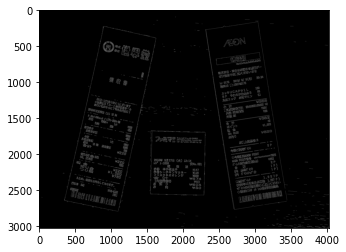

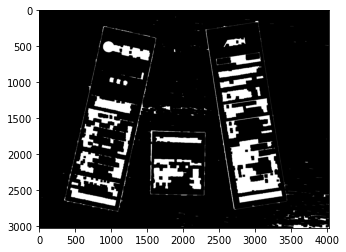

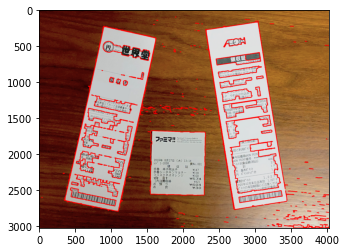

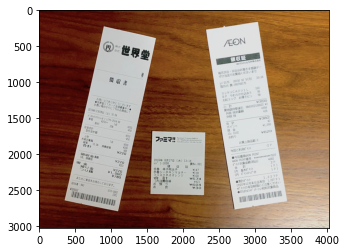

In [20]:
get_receipt_contours(input_file)

## 案4 適応的しきい値処理

adaptiveThreshold(src, maxValue, adaptiveMethod, thresholdType, blockSize, C[, dst])

- adaptiveMethod：小領域中でのしきい値の計算方法
  - cv2.ADAPTIVE_THRESH_MEAN_C : 近傍領域の中央値をしきい値とする
  - cv2.ADAPTIVE_THRESH_GAUSSIAN_C : 近傍領域の重み付け平均値をしきい値とする　重みの値はGaussian分布になるように計算
- Block Size： しきい値計算に使用する近傍領域のサイズ（奇数とする）
- C： 計算されたしきい値から引く定数

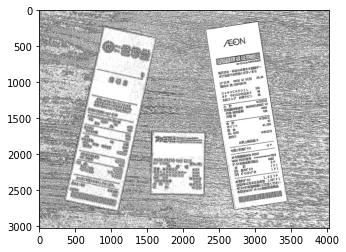

In [21]:
th2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
plot_img(th2)

block_sizeを変えて結果の違いを見てみる

block_size: 11


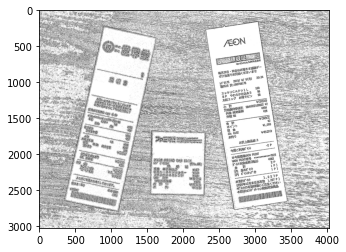

block_size: 101


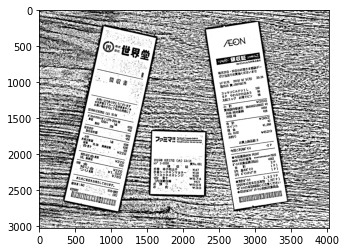

block_size: 1001


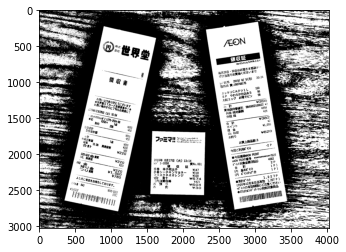

In [22]:
for block in [11, 101, 1001]:
    th2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block, 2)
    print('block_size:', block)
    plot_img(th2)

Cを変えて結果の違いを見てみる

C: 1


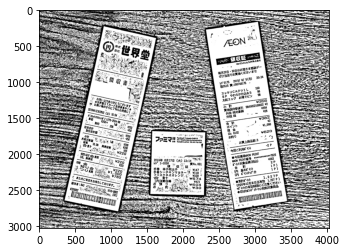

C: 3


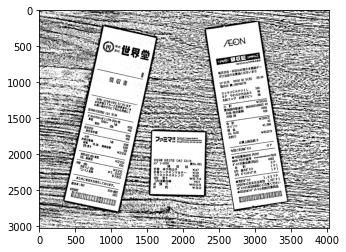

C: 5


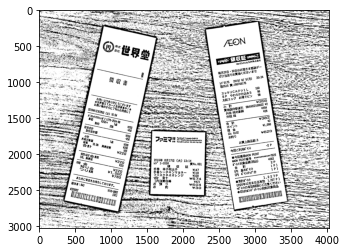

In [23]:
for C in [1, 3, 5]:
    th2 = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, C)
    print('C:', C)
    plot_img(th2)

In [24]:
def binarize(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 425, 2)
    plot_img(binary_img)
    return binary_img


def noise_reduction(img):
    kernel = np.ones((10,10), np.uint8)
    #closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
    #plot_img(closing)
    #dilation = cv2.dilate(img, kernel, iterations = 1)
    #plot_img(dilation)
    median = cv2.medianBlur(img, 5)
    plot_img(median)
    #return closing
    #return dilation
    return median


def find_contours(img):
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def approximate_contours(img, contours):
    height, width, _ = img.shape
    img_size = height * width
    approx_contours = []
    for i, cnt in enumerate(contours):
        arclen = cv2.arcLength(cnt, True)
        area = cv2.contourArea(cnt)
        if arclen != 0 and img_size*0.02 < area < img_size*0.9:
            #approx_contour = cv2.approxPolyDP(cnt, epsilon=0.01*arclen, closed=True)
            approx_contour = cv2.approxPolyDP(cnt, epsilon=0.05*arclen, closed=True)
            if len(approx_contour) == 4:  # 四角形として検知できていない場合は無視する
                approx_contours.append(approx_contour)
    return approx_contours


def draw_contours(img, contours):
    draw_contours_file = cv2.drawContours(img.copy(), contours, -1, (0, 0, 255, 255), 10)
    plot_img(draw_contours_file)


def plot_img(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    # cv2.imwrite('./{}.png'.format(time.time()), img)


def get_receipt_contours(img):
    binary_img = binarize(img)
    binary_img = noise_reduction(binary_img)
    contours = find_contours(binary_img)
    approx_contours = approximate_contours(img, contours)
    draw_contours(img, contours)
    draw_contours(img, approx_contours)

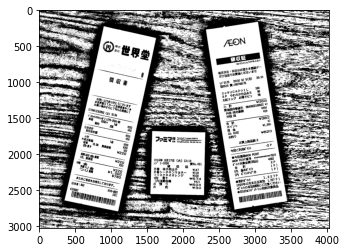

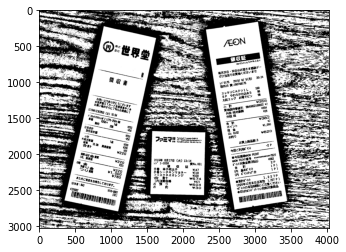

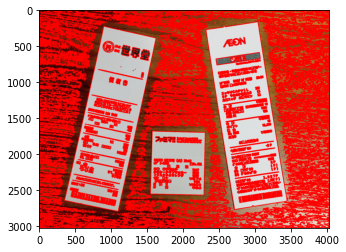

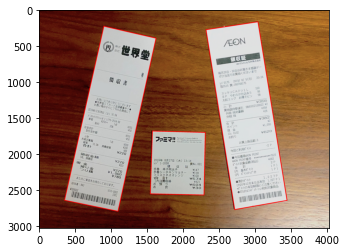

In [25]:
get_receipt_contours(input_file)

## 案5 ハフ変換

- threshold：ある直線上に乗った点の数がこの値を超えたら直線として検出
- minLineLength：この値以上の長さを持つ線を直線として検出
- maxLineGap：点間の間隔がこの値より小さければ同一の線とみなす

minlinelength:10 maxlinegap:10


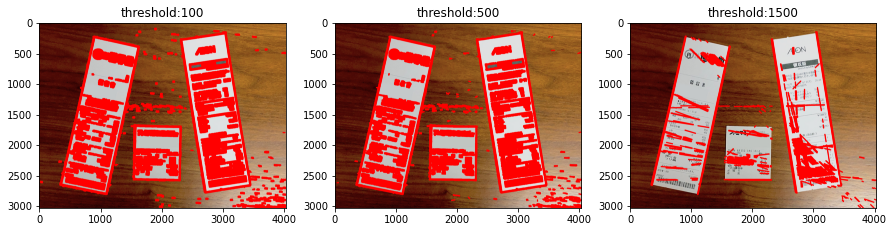

threshold:500 maxlinegap:10


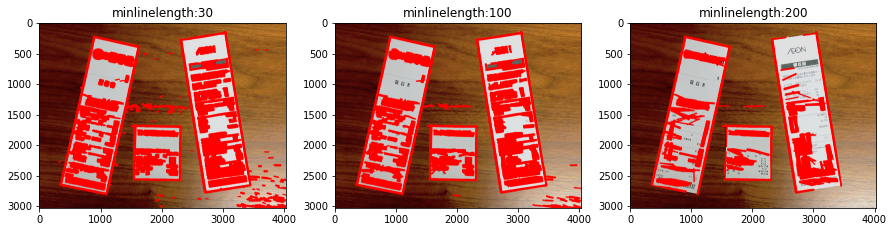

threshold:500 minlinelength:100


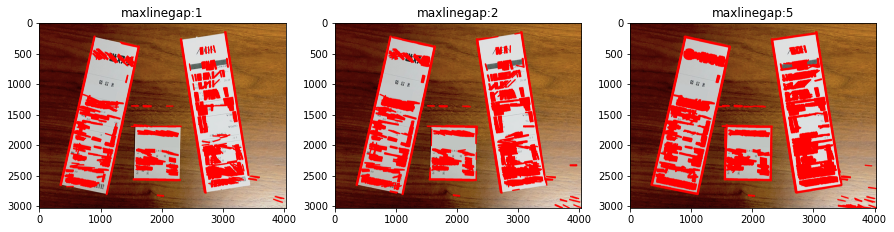

In [26]:
def houghlinesp(threshold, minlinelength, maxlinegap):
    canny = cv2.Canny(gray_img, 100, 200)
    kernel = np.ones((20,20), np.uint8)
    dilation = cv2.dilate(canny, kernel, iterations = 1)
    lines = cv2.HoughLinesP(dilation, rho=1, theta=np.pi/180, 
                            threshold=threshold, minLineLength=minlinelength, maxLineGap=maxlinegap)
    line_list = []
    for line in lines:
        line_list.append(np.array([(line[0][0], line[0][1]), (line[0][2], line[0][3])]))
    red_line_img = cv2.polylines(input_file.copy(), line_list, False, (0, 0, 255), 20)
    return red_line_img


thresholds = [100, 500, 1500]
minlinelength = 10
maxlinegap = 10
print('minlinelength:{} maxlinegap:{}'.format(minlinelength, maxlinegap))
plt.figure(figsize=(15, 10))
for i, threshold in enumerate(thresholds):
    red_line_img = houghlinesp(threshold, minlinelength, maxlinegap)
    plt.subplot(1, 3, i+1)
    plt.title('threshold:{}'.format(threshold))
    plt.imshow(cv2.cvtColor(red_line_img, cv2.COLOR_BGR2RGB))
plt.show()

threshold = 500
minlinelengths = [30, 100, 200]
maxlinegap = 10
print('threshold:{} maxlinegap:{}'.format(threshold, maxlinegap))
plt.figure(figsize=(15, 10))
for i, minlinelength in enumerate(minlinelengths):
    red_line_img = houghlinesp(threshold, minlinelength, maxlinegap)
    plt.subplot(1, 3, i+1)
    plt.title('minlinelength:{}'.format(minlinelength))
    plt.imshow(cv2.cvtColor(red_line_img, cv2.COLOR_BGR2RGB))
plt.show()

threshold = 500
minlinelength = 100
maxlinegaps = [1, 2, 5]
print('threshold:{} minlinelength:{}'.format(threshold, minlinelength))
plt.figure(figsize=(15, 10))
for i, maxlinegap in enumerate(maxlinegaps):
    red_line_img = houghlinesp(threshold, minlinelength, maxlinegap)
    plt.subplot(1, 3, i+1)
    plt.title('maxlinegap:{}'.format(maxlinegap))
    plt.imshow(cv2.cvtColor(red_line_img, cv2.COLOR_BGR2RGB))
plt.show()